## TP2 : Classification using Linear & Quadratic Discriminant Analysis

First think of configuring your notebook :

In [7]:
import csv
# import os
from pylab import *
import numpy as np
from numpy import linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#masquer les warning
import warnings
warnings.filterwarnings('ignore')

## Reading synthetic data
Load the training and test data sets |synth_train.txt| and
|synth_test.txt| already used for Knn. Targets belong to {1,2} and entries belong to R^2.
We have 100 training data samples and 200 test samples.

* the 1st column contains the label of the class the sample, 
* columns 2 & 3 contain the coordinates of each sample in 2D.

In [4]:
train = np.loadtxt('synth_train.txt')
test = np.loadtxt('synth_test.txt')

## Recall about the main steps of discriminant analysis:
* estimation of weights `pi_1` and `pi_2` for each class,
* estimation of empirical means `mu_1` and `mu_2` for each class, 
* estimation of empirical covariance matrices  `sigma_1` and `sigma_2`,
* computation of the common averaged covariance `sigma` (average of intra-class covariances),
* computation of log-probabilities of belonging to each class,
* decision of classification,
* display results.


## TO DO : linear & quadratic discriminant analysis (LDA & QDA)
1. Implement a classifier using LDA of the data set. 
2. Then implement QDA classification.
3. In each case (LDA & QDA) show the decision boundary and
compute the error rate respectively for the training set and the test set. 
4. Compare and comment on your results with LDA and QDA.
5. You may also compare your results to K nearest neighbours.

_Indication 1 : matrices `sigma` are of size 2x2.
More generally, be careful of the sizes of vectors and matrices you
manipulate._

_Indication 2 : to display the regions of decision, you may use:_


### 0. Importation of dataset

In [5]:
# Training Set
X_train = train[:, 1:]
y_train = train[:,0]

# Testing Set
X_test = test[:, 1:]
y_test = test[:,0]

#with panda
pd_train=pd.DataFrame(train,columns=['classe','x','y'])
pd_test=pd.DataFrame(test,columns=['classe','x','y'])

In [10]:
# Definition of dimensions and classes
N, D = X_train.shape
C = np.unique(y_train)
K = C.shape[0]

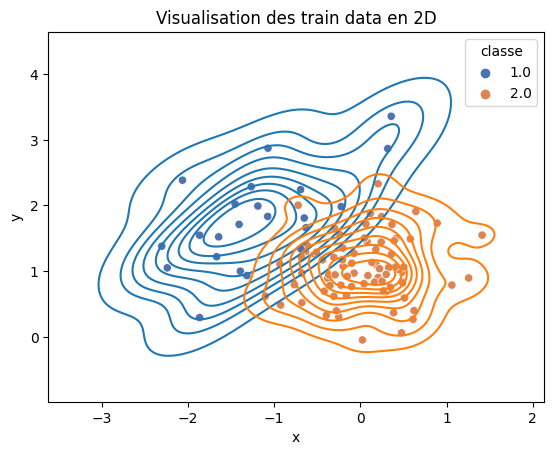

In [8]:
sns.scatterplot(pd_train,x="x",y="y",hue="classe",palette="deep")
sns.kdeplot(data=pd_train.query("classe==1"), x="x", y="y")
sns.kdeplot(data=pd_train.query("classe==2"), x="x", y="y")
plt.title("Visualisation des train data en 2D")
plt.show()

**Commentaires**: ce graphique nous permet de visualiser comment se répartissent les points de l'ensemble train. On que la frontière n'est pas clairement définie et que les distributions de points se recoupent (cf courbe de niveau). Par ailleurs, au vu de ce plot il est difficile de se prononcer sur quel model (LDA ou QDA) sera plus efficace. En effet la frontière entre les 2 clusters semble linéaire ce qui laisserai supposer de meilleurs résultats avec LDA mais peut être que l'approche quadratique du problème donnera de bons résultats également.

### 1./2. Implementation of LDA and QDA classifiers

**Commentaire**: dans un premier temps, on va estimer tous les paramètres en utilisant les résultats vu en cours par MLE.

**Commentaire**: pour les Algo de classifiaction par analyse discrimiantes, on choisit la classe qui maximise la fonction de décision $y_k$. On va utiliser les resultats de cours pour coder ces fonction qui changent en fonction de LDA ou QDA. Ensuite, l'idée des algorithmes de classification est de, pour chaque point à classer, calculer l'image de ce point par la fonction de décision et lui attribuer la classe associée à la plus grande valeur. 

In [11]:
# Computation of parameters
Pi, Sigma, sigma, mu = np.zeros((K)), np.zeros((K, D, D)), np.zeros((D, D)), np.zeros((K, D))
for k in range(K):
    X_train_k = X_train[y_train == C[k]]
    N_k = X_train_k.shape[0]
    Pi[k] = N_k / N
    mu[k] = np.mean(X_train_k, axis=0)
    S_k = (X_train_k - mu[k]).T @ (X_train_k - mu[k])
    Sigma[k] = S_k / N_k
    sigma += S_k / N

In [12]:
def f(x, method):
    return np.argmax([y_k(x, k, method) for k in range(K)])

def y_k(x, k, method):
    x = x.reshape(2, 1)
    mu_k = mu[k].reshape(2, 1)
    if method == "LDA":
        value = x.T @ la.inv(sigma) @ mu_k + np.log(Pi[k]) -  mu_k.T @ la.inv(sigma) @  mu_k / 2
    if method == "QDA":    
        value = - (x - mu_k).T @ la.inv(Sigma[k]) @ (x - mu_k) / 2 + np.log(Pi[k]) - np.log(la.det(Sigma[k]))
    return value[0, 0]

### 3. Representation of decision boundaries and computation of error rates

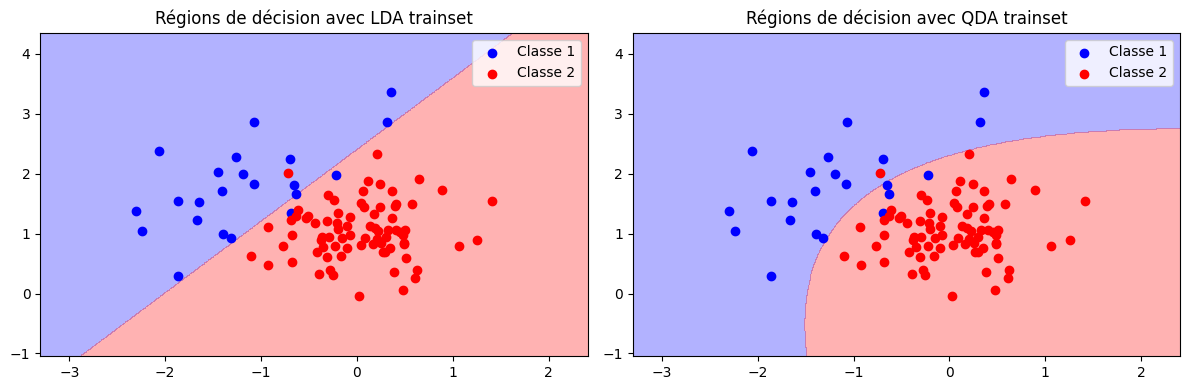

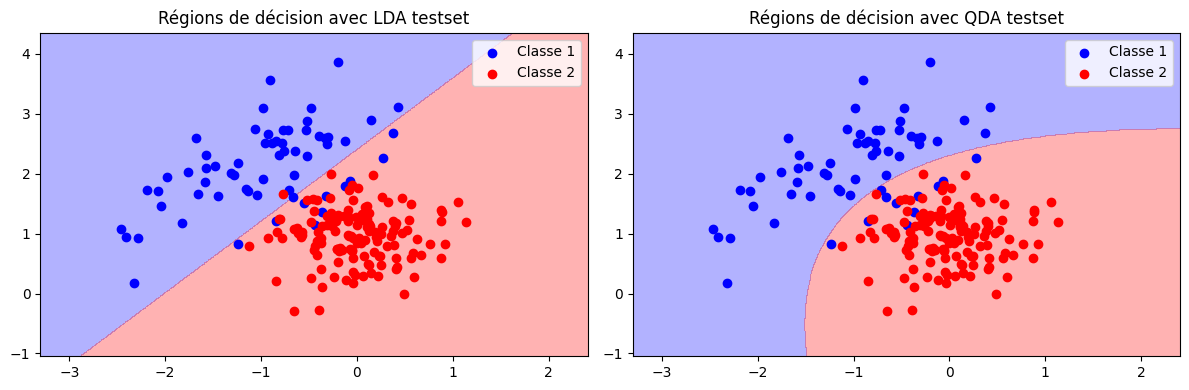

In [13]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

def plot_decision_regions(ax, method, title, type):
    Z = np.array([f(np.array([x, y]), method) for x, y in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)
    colors = ['blue', 'red', 'white']
    ax.contourf(xx, yy, Z, alpha=0.3, levels=[-1, 0, 1], colors=colors)

    if type == "train":
        for k in range(K):
            ax.scatter(X_train[y_train == C[k]][:, 0], X_train[y_train == C[k]][:, 1], label=f'Classe {int(C[k])}', color=colors[k])
    if type == "test":
        for k in range(K):
            ax.scatter(X_test[y_test == C[k]][:, 0], X_test[y_test == C[k]][:, 1], label=f'Classe {int(C[k])}', color=colors[k])

    ax.set_title(title)
    ax.legend()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_decision_regions(axs[0], "LDA", "Régions de décision avec LDA trainset", "train")
plot_decision_regions(axs[1], "QDA", "Régions de décision avec QDA trainset", "train")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_decision_regions(axs[0], "LDA", "Régions de décision avec LDA testset", "test")
plot_decision_regions(axs[1], "QDA", "Régions de décision avec QDA testset", "test")
plt.tight_layout()
plt.show()

### 4. Comparaison and comments for LDA and QDA

In [9]:
def predict_labels(X, method):
    return np.array([C[f(x, method)] for x in X])

def error_rate(predictions, true_labels):
    incorrect_predictions = np.sum(predictions != true_labels)
    total_samples = len(true_labels)
    return incorrect_predictions / total_samples

In [10]:
# Predict labels for training set and test set
train_predictions_lda = predict_labels(X_train, "LDA")
test_predictions_lda = predict_labels(X_test, "LDA")
train_predictions_qda = predict_labels(X_train, "QDA")
test_predictions_qda = predict_labels(X_test, "QDA")

# Compute error rates
error_rate_train_lda = error_rate(train_predictions_lda, y_train)
error_rate_test_lda = error_rate(test_predictions_lda, y_test)
error_rate_train_qda = error_rate(train_predictions_qda, y_train)
error_rate_test_qda = error_rate(test_predictions_qda, y_test)

# Print the error rates
print(f"Error rate for LDA on the training set: {error_rate_train_lda:.2%}")
print(f"Error rate for LDA on the test set: {error_rate_test_lda:.2%}")
print(f"Error rate for QDA on the training set: {error_rate_train_qda:.2%}")
print(f"Error rate for QDA on the test set: {error_rate_test_qda:.2%}")

Error rate for LDA on the training set: 3.00%
Error rate for LDA on the test set: 5.50%
Error rate for QDA on the training set: 5.00%
Error rate for QDA on the test set: 5.50%


**Commentaire**: 
Graphiquement on peut voir que notre intuition se confirme. Dans le cadre de ce modèle, le LDA est plus performant que le QDA sur le trainset et testset. C'est dû au fait que la frontière de décision soit visuellement linéaire. Cette observation se vérifie clairement lorsqu'on calcule les erreurs de classification sur le train set et le test set. Dans chaque set utilisé, l'erreur est abaissée lorsqu'on utilise un classifieur LDA. On remarque cependant que l'erreur du QDA dimunue significativement sur le test set ce qui peut nous questionner sur le choix des test et trainset: en effet, peut etre qu'en ayant plus de données ou en mélangeant les données les résultats seraient améliorés. 

### 5. Comparaison and comments for K-NN

In [10]:
from sklearn.neighbors import KNeighborsClassifier

# Predict labels for training set and test set
knn = KNeighborsClassifier(n_neighbors=2) 
knn.fit(X_train, y_train)
train_predictions_knn = knn.predict(X_train)
test_predictions_knn = knn.predict(X_test)

# Compute error rates
error_rate_train_knn = error_rate(train_predictions_knn, y_train)
error_rate_test_knn = error_rate(test_predictions_knn, y_test)

# Print the error rates
print(f"Error rate for Scikit-k-NN on the training set: {error_rate_train_knn:.2%}")
print(f"Error rate for Scikit-k-NN on the test set: {error_rate_test_knn:.2%}")

Error rate for Scikit-k-NN on the training set: 3.00%
Error rate for Scikit-k-NN on the test set: 6.00%


**Commentaires:** On observe que l'algorithme K-NN a des performances du même ordre de grandeur que les autres algorithmes et qui reste raisonnable pour assurer une bonne performance.

## TO DO : LDA & QDA using scikit-learn module

The module `scikit-learn` is dedicated to machine learning algorithms. Many of them are available in a simple manner. For LDA and QDA, have a look at the tutorial available at http://scikit-learn.org/stable/modules/lda_qda.html 

**Warning** : you may have a critical view of the way LDA and QDA are illustrated in the proposed example...




In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# Predict labels for training set and test set
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)
train_predictions_lda_sklearn = lda_model.predict(X_train)
test_predictions_lda_sklearn = lda_model.predict(X_test)
qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_train, y_train)
train_predictions_qda_sklearn = qda_model.predict(X_train)
test_predictions_qda_sklearn = qda_model.predict(X_test)

# Compute error rates
error_rate_train_lda_sklearn = error_rate(train_predictions_lda_sklearn, y_train)
error_rate_test_lda_sklearn = error_rate(test_predictions_lda_sklearn, y_test)
error_rate_train_qda_sklearn = error_rate(train_predictions_qda_sklearn, y_train)
error_rate_test_qda_sklearn = error_rate(test_predictions_qda_sklearn, y_test)

# Print the error rates
print(f"Error rate for Scikit-LDA on the training set: {error_rate_train_lda_sklearn:.2%}")
print(f"Error rate for Scikit-LDA on the test set: {error_rate_test_lda_sklearn:.2%}")
print(f"Error rate for Scikit-QDA on the training set: {error_rate_train_qda_sklearn:.2%}")
print(f"Error rate for Scikit-QDA on the test set: {error_rate_test_qda_sklearn:.2%}")

Error rate for Scikit-LDA on the training set: 3.00%
Error rate for Scikit-LDA on the test set: 5.50%
Error rate for Scikit-QDA on the training set: 5.00%
Error rate for Scikit-QDA on the test set: 5.00%


**Commentaires:** La principale différence avec notre implémentation des classifieur et celle de sk-learn vient du fait que sklearn utilise un solveur pour trouver les frontières de décision. Ayant un petit data set à 2 composants, la solution était implémentable numériquement. On remarque d'ailleurs que les résultats ne sont pas différents entre notre LDA/QDA et celui de sk-learn.